<span style="color: lightblue;">
<span style="font-size:12px;">

CNN은 “위치는 중요하고, 관계는 천천히 배운다”    
ViT는 “관계가 중요하고, 위치는 배워서 안다”  

<br>

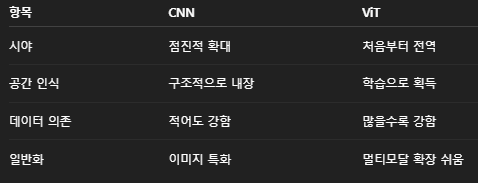

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys, os

<span style="color: Gold"> 1. 패치분할

In [2]:
def patch_embedding():
    '''이미지를 패치로 분할하는 과정(patch embedding)'''
    # 설정
    image_size = 224
    patch_size = 16
    channels = 3
    embedding_dim = 768

    # 패치수 계산
    num_patchs = (image_size // patch_size) **2
    print(f' 이미지 크기 : {image_size} x {image_size }')
    print(f' 패치 크기 : {patch_size} x {patch_size }')
    print(f' 채널 수 : {channels}')
    print(f' 패치 수 : {image_size // patch_size} x{image_size // patch_size}')

    # 더미 이미지 생성
    dummy_image = torch.randn(1,channels, image_size, image_size)
    print(f' 더미 이미지 생성')
    print(f' 입력 이미지 shape : {dummy_image.shape}') # [1,3,224,224]

    # 패치분할(conv2 사용)
    # conv2 stride = patch_size 겹치지 않는 패치 추출 / # stride = 커널이 한 번에 몇 칸씩 이동하느냐
    patch_embed = nn.Conv2d(in_channels=channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size) # 입력하는 채널의 수, 출력하는 채널의 수, kernel_size -> 몇개씩 도장을 찍느냐, stride -> 이동 간격

    # 패치 임베딩 적용
    patches = patch_embed(dummy_image)
    print(f' \n 패치 임베딩 후')
    print(f' conv2d 출력 shape : {patches.shape}') # [1, 768, 14, 14]

    # Flatten : (배치사이즈(B), 임베딩 차이(D), 이미지 높이(H), 이미지 넓이(W)) -> (B, 196(HxW), D) -> (1, 196, 768)
    patches_flat = patches.flatten(2).transpose(1,2)
    print(f' Flatten 후 shape : {patches_flat.shape}') # [1, 196, 768]

    # 각 패치는 768차원 벡터
    print(f' \n 패치 수  : {patches_flat.shape[1]}')
    print(f' 각 패치의 임베딩 차원 수  : {patches_flat.shape[2]}')
    return patches_flat

if __name__ == '__main__':
    patch_embedding()

 이미지 크기 : 224 x 224
 패치 크기 : 16 x 16
 채널 수 : 3
 패치 수 : 14 x14
 더미 이미지 생성
 입력 이미지 shape : torch.Size([1, 3, 224, 224])
 
 패치 임베딩 후
 conv2d 출력 shape : torch.Size([1, 768, 14, 14])
 Flatten 후 shape : torch.Size([1, 196, 768])
 
 패치 수  : 196
 각 패치의 임베딩 차원 수  : 768


<span style="color: Gold"> 2. 위치 임베딩의 역할

In [3]:
def positional_embedding():
    '''위치 임베딩'''
    num_patches = 196
    embedding_dim = 768

    # 위치 임베딩 생성  
    # 이 텐서는 학습대상 Optimizer 에 의해 업데이트
    position_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim)) # num_patches+1 -> +1을 하는 이유는 cls 토큰을 추가하기 위해서
    print(f' 위치 임베딩 shape : {position_embedding.shape}')
    print(f' 총 위치 수 : {num_patches+1} (패치 196 + cls 토큰 1개)')

    # 배치 차원 제거 -> 각 위치를 하나의 벡터로 다루기 위해 배치 크기가 1인 형태는 분석 시 불필요
    pos_emb = position_embedding.squeeze(0) #squeeze(0)-> 첫번째(배치크기)를 숨긴다

    # 코사인 유사도 계산을 위해서 정규화는 필수 -> 코사인 유사도를 하는 이유는 의미의 방향만 비교하려고 사용
    # 위치 정보
    # → positional embedding으로 해결
    # 의미 관계
    # → attention + 코사인 유사도(정규화 내적)로 해결
    pos_emb_norm = pos_emb/pos_emb.norm(dim=1,keepdim=True) # 단위벡터로 나눔
    # 코사인 유사도 행렬
    similarity = torch.mm(pos_emb_norm,pos_emb_norm.t())    # [197,197]
    # 지금은 학습전이라서 랜덤이지만 학습 후에는 인접 패치까지 유사해짐
    return position_embedding

if __name__ == '__main__':
    positional_embedding()

 위치 임베딩 shape : torch.Size([1, 197, 768])
 총 위치 수 : 197 (패치 196 + cls 토큰 1개)


<span style="font-size:12px;"> 
<span style="color: lightblue"> Self-Attention 핵심 정리 </span>


**1. 내적(Dot Product)이란?**
- 두 벡터가 얼마나 같은 방향을 보는지를 하나의 숫자로 나타낸 것
- 의미
    - 방향이 비슷할수록 값이 큼
    - 직각이면 0
    - 반대 방향이면 음수
    - 벡터의 크기도 함께 반영됨

👉 **내적 = 방향 유사도 + 크기 영향**

**2. Attention의 전체 흐름**

- 내적(Dot Product) → 관련성
- 스케일링(√d)      → 안정성
- Softmax          → 선택
- 가중합(Σ w·V)    → 정보 조합

**3. 왜 Q · K 가 “관련성”이 되는가**

Attention이 묻는 핵심 질문:
> “이 토큰은 다른 어떤 토큰을 참고해야 하나?”

이를 수식으로 표현하면:
```text
Query · Key
```

* **Query(Q)** : 내가 찾고 있는 방향
* **Key(K)**   : 내가 가지고 있는 방향

```text
방향이 맞음 → 내적 큼 → 주목
방향 다름 → 내적 작음 → 무시
```

👉 그래서 **Q · K = 관련성 점수**


**4. Query / Key / Value의 역할**
- Query (Q)
> "나는 무엇을 찾고 있나?"

- Key (K)
> "나는 어떤 특징을 갖고 있나?"

- Value (V)
> "내가 실제로 전달할 정보는 무엇인가?"

👉 **Q, K, V는 모두 같은 토큰 임베딩에서 나온 서로 다른 표현**


**5. 벡터 크기(scale)의 의미**

* 중요한 특징 → 벡터 크기 큼
* 약한 특징 → 벡터 크기 작음

하지만 차원(d)이 커질수록:

```text
Q · K 값이 과도하게 커짐
→ softmax가 한쪽으로 쏠림
→ gradient 소실 / 폭주
```

그래서 사용:

```text
(Q · K) / √d
```

👉 **스케일링 = 학습 안정성 확보**

**6. Softmax의 역할**

> **관련성 점수를 확률 분포로 변환하는 단계**

* 모든 값의 합 = 1
* 상대적 중요도만 남김

👉 여러 후보 중 **무엇을 얼마나 참고할지 선택**


**7. 최종 Attention 계산 요약**

```text
Q · K          → 누구를 볼지 결정
softmax       → 얼마나 볼지 결정
Σ(weight × V) → 실제 정보 조합
```


**8. 핵심 구조 요약 (반드시 기억)**

```text
Query · Key  → 관계 판단용
Value        → 정보 전달용
```

👉 **판단과 내용은 분리돼야 한다**


**9. 한 문장 요약**

> **Self-Attention은
> “누가 중요한지를 판단(Q·K)하고,
> 그 정보(Value)를 비율대로 섞는 메커니즘이다.”**


<span style="color: Gold"> 3. CLS 토큰

In [4]:
def cls_token():
    embedding_dim = 768
    num_paches = 196
    batch_size = 2
    
    # cls 토큰 생성
    cls_token = nn.Parameter(torch.rand(1,1,embedding_dim)) # 학습을 통해 이미지를 요약하는 벡터로 진화
    print(f' CLS 토큰 shape : {cls_token.shape}')   # [1,1,768]
    # 배치 크기에 맞게 CLS 토큰 확장
    cls_tokens = cls_token.expand(batch_size,-1,-1) # 배치마다 동일한 cls 토큰이 필요, expand는 view만 확장
    print(f' 배치 확장 shape : {cls_tokens.shape}')   # [2,1,768]
    # 패치 임베딩 생성
    patch_embeddings = torch.randn(batch_size, num_paches, embedding_dim)
    print(f' 패치 임베딩 shape : {patch_embeddings.shape}')
    # CLS 토큰을 시퀀스 맨 앞에 추가
    embeddings = torch.cat([cls_tokens,patch_embeddings], dim=1)    # dim=1 -> 토큰 차원 / [cls, patch1 ,... patch 196]
    print(f'결합후shape : {embeddings.shape}') # [2,197,768]
    return embeddings

if __name__ == '__main__':
    cls_token()


 CLS 토큰 shape : torch.Size([1, 1, 768])
 배치 확장 shape : torch.Size([2, 1, 768])
 패치 임베딩 shape : torch.Size([2, 196, 768])
결합후shape : torch.Size([2, 197, 768])


<span style="color: Gold"> 4. self-attention

In [5]:
def self_attention():
    '''self_aattention 메커니즘
    Mult-Head self-attention의 구성요소
    Q(query)
    K(key)
    V(value)
    '''
    embedding_dim = 768
    num_heads = 12
    head_dim = embedding_dim//num_heads # 각 헤드가 담당하는차원
    selq_len = 197 # 196패치 +1 cls
    batch_size = 1  # 샘플1개
    # 더미데이터 생성
    x = torch.randn(batch_size,selq_len,embedding_dim) # [1,197,768]
    # QKV 선형 레이어
    qkv_proj = nn.Linear(embedding_dim,embedding_dim*3) # 하나의 Linear 연산으로 QKV 동시에 생성
    # QKV 계산
    qkv = qkv_proj(x)
    print(f' QKV shape : {qkv.shape}')
    # Q K V 분리
    qkv = qkv.reshape(batch_size, selq_len,3, num_heads, head_dim) # [B, N, 3, heads, head_dim]
    qkv = qkv.permute(2,0,3,1,4) # [3,B,heads,N,head_dim]
    q, k , v = qkv[0], qkv[1], qkv[2]
    print(f' Q shape : {q.shape}')
    print(f' K shape : {k.shape}')
    print(f' V shape : {v.shape}')


# Attention Score 계산
    scale = head_dim ** -0.5
    attn = (q @ k.transpose(-2, -1)) * scale
    print(f"\n[Attention Score]")
    print(f"  Attention shape: {attn.shape}")  # [1, 12, 197, 197]
    
    # Softmax
    attn = attn.softmax(dim=-1)
    print(f"  Softmax 후 합계 (각 행): {attn[0, 0, 0].sum().item():.4f}")  # 1.0
    
    # Value와 곱하기
    out = attn @ v
    print(f"\n[Attention 적용]")
    print(f"  출력 shape: {out.shape}")  # [1, 12, 197, 64]
    
    # 헤드 결합
    out = out.transpose(1, 2).reshape(batch_size, selq_len, embedding_dim)
    print(f"  헤드 결합 후: {out.shape}")  # [1, 197, 768]
    
    return attn


if __name__ == '__main__':
    self_attention()
    

 QKV shape : torch.Size([1, 197, 2304])
 Q shape : torch.Size([1, 12, 197, 64])
 K shape : torch.Size([1, 12, 197, 64])
 V shape : torch.Size([1, 12, 197, 64])

[Attention Score]
  Attention shape: torch.Size([1, 12, 197, 197])
  Softmax 후 합계 (각 행): 1.0000

[Attention 적용]
  출력 shape: torch.Size([1, 12, 197, 64])
  헤드 결합 후: torch.Size([1, 197, 768])


Multi-Head Self-Attention은
“하나의 시선으로는 놓치는 관계를
여러 관점에서 동시에 보게 만드는 장치”

-> Single-Head Attention는 부족한 이유는 이미지는 문장과 달리 
색깔 기준, 형태 기준, 위치 기준, 질감 기준 이 전부 동시에 중요하다.

2️⃣ Multi-Head의 핵심 아이디어
같은 입력을

“차원을 나눠서” head를 만드는가

임베딩 768 차원을 그대로 하나로 쓰면:

관계가 섞인다

특정 패턴이 묻힌다


왜 다시 합치나 (Concat + Linear)

각 head는 부분 관점이다.

그래서 마지막에:

[Head1 | Head2 | ...] → Linear → 통합


👉 여러 시선을 하나의 의미 공간으로 재조합

<span style="color: Gold"> 5. Multi-Layer Perceptron </span>   
- Attention이 모은 정보를 다시 가공하는 단계
- Attention은 “어디를 볼지” 결정하고, MLP는 “본 걸 어떻게 해석할지” 결정

In [6]:
def mlp():
    '''mlp 블럭'''
    embedding_dim = 768
    mlp_dim = embedding_dim*4 # 일반적으로 4배 확장
    print(f' 입력/ 출력 차원 : {embedding_dim}')
    print(f'히든차원 : {mlp_dim}')
    # MLP 블럭 정의
    mlp = nn.Sequential(
        nn.Linear(embedding_dim,mlp_dim),
        nn.GELU(), # 단순선형을 비선형으로 변형
        nn.Linear(mlp_dim,embedding_dim)
    )
    
     # 파라미터 수 계산
    total_params = sum(p.numel() for p in mlp.parameters())
    print(f"  MLP 파라미터 수: {total_params:,}")
    
    # 더미 입력
    x = torch.randn(1, 197, embedding_dim)
    print(f"\n[입력/출력]")
    print(f"  입력 shape: {x.shape}")
    
    # MLP 적용
    out = mlp(x)
    print(f"  출력 shape: {out.shape}")
    
    print(f"\n[GELU 활성화 함수]")
    print(f"  GELU(x) = x * Phi(x)")
    print(f"  ReLU보다 부드럽고, 음수 입력에도 작은 값 출력")
    
    return out


<span style="color: Gold"> 6. transformer encoder block 구조

In [7]:
def transformer_block():
    '''Transformer Encoder 블럭'''
    class TransformerBlock(nn.Module):
        """간단한 Transformer Block 구현"""
        def __init__(self, dim=768, num_heads=12, mlp_ratio=4.0):
            super().__init__()
            self.norm1 = nn.LayerNorm(dim)
            self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
            self.norm2 = nn.LayerNorm(dim)
            self.mlp = nn.Sequential(
                nn.Linear(dim, int(dim * mlp_ratio)),
                nn.GELU(),
                nn.Linear(int(dim * mlp_ratio), dim),
            )
        
        def forward(self, x):
            # Pre-norm 구조
            # Attention with residual
            x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
            # MLP with residual
            x = x + self.mlp(self.norm2(x))
            return x
    
    # 블록 생성
    block = TransformerBlock()
    
    # 파라미터 수
    total_params = sum(p.numel() for p in block.parameters())
    print(f"\n[Transformer Block 구성]")
    print(f"  1. Layer Normalization")
    print(f"  2. Multi-Head Self-Attention")
    print(f"  3. Residual Connection")
    print(f"  4. Layer Normalization")
    print(f"  5. MLP (Feed-Forward)")
    print(f"  6. Residual Connection")
    print(f"\n  블록당 파라미터 수: {total_params:,}")
    
    # 더미 입력
    x = torch.randn(1, 197, 768)
    print(f"\n[입력/출력]")
    print(f"  입력 shape: {x.shape}")
    
    out = block(x)
    print(f"  출력 shape: {out.shape}")
    
    # ViT-Base는 12개 블록
    print(f"\n[ViT-Base 전체 파라미터]")
    print(f"  12개 블록 파라미터: {total_params * 12:,}")
    
    return block


In [8]:
if __name__ == '__main__':
    # 1. 패치임베딩
    patcheds = patch_embedding()
    # 2. 위치 임베딩
    pos_embed = positional_embedding()
    # 3. CLS 토큰
    embeddings = cls_token()
    # 4. self_attention
    attention = self_attention()
    # 5. mlp
    mlp_output = mlp()
    # 6. transformer block
    block = transformer_block()

 이미지 크기 : 224 x 224
 패치 크기 : 16 x 16
 채널 수 : 3
 패치 수 : 14 x14
 더미 이미지 생성
 입력 이미지 shape : torch.Size([1, 3, 224, 224])
 
 패치 임베딩 후
 conv2d 출력 shape : torch.Size([1, 768, 14, 14])
 Flatten 후 shape : torch.Size([1, 196, 768])
 
 패치 수  : 196
 각 패치의 임베딩 차원 수  : 768
 위치 임베딩 shape : torch.Size([1, 197, 768])
 총 위치 수 : 197 (패치 196 + cls 토큰 1개)


 CLS 토큰 shape : torch.Size([1, 1, 768])
 배치 확장 shape : torch.Size([2, 1, 768])
 패치 임베딩 shape : torch.Size([2, 196, 768])
결합후shape : torch.Size([2, 197, 768])
 QKV shape : torch.Size([1, 197, 2304])
 Q shape : torch.Size([1, 12, 197, 64])
 K shape : torch.Size([1, 12, 197, 64])
 V shape : torch.Size([1, 12, 197, 64])

[Attention Score]
  Attention shape: torch.Size([1, 12, 197, 197])
  Softmax 후 합계 (각 행): 1.0000

[Attention 적용]
  출력 shape: torch.Size([1, 12, 197, 64])
  헤드 결합 후: torch.Size([1, 197, 768])
 입력/ 출력 차원 : 768
히든차원 : 3072
  MLP 파라미터 수: 4,722,432

[입력/출력]
  입력 shape: torch.Size([1, 197, 768])
  출력 shape: torch.Size([1, 197, 768])

[GELU 활성화 함수]
  GELU(x) = x * Phi(x)
  ReLU보다 부드럽고, 음수 입력에도 작은 값 출력

[Transformer Block 구성]
  1. Layer Normalization
  2. Multi-Head Self-Attention
  3. Residual Connection
  4. Layer Normalization
  5. MLP (Feed-Forward)
  6. Residual Connection

  블록당 파라미터 수: 7,087,872

[입력/출력]
  입력 shape: torch.Size([1, 197, 768])
  출력 shape: torch.Size([1, 197, 7

시각화(더미데이터)

 QKV shape : torch.Size([1, 197, 2304])
 Q shape : torch.Size([1, 12, 197, 64])
 K shape : torch.Size([1, 12, 197, 64])
 V shape : torch.Size([1, 12, 197, 64])

[Attention Score]
  Attention shape: torch.Size([1, 12, 197, 197])
  Softmax 후 합계 (각 행): 1.0000

[Attention 적용]
  출력 shape: torch.Size([1, 12, 197, 64])
  헤드 결합 후: torch.Size([1, 197, 768])


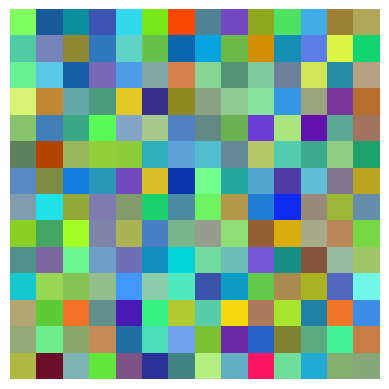

In [9]:
def _visualization_cls_attention(atten, image_size=224, patch_size=16):
    '''cls 토큰이 각 패치를 얼마나 주목하는지 시각화
    attention : [1, heads, 197, 197]
    '''
    # cls - > patch attention만 추출
    cls_atten = atten[0, :, 0, 1:]  # [heads, 196]
    # head 평균
    cls_atten_mean = cls_atten.mean(dim = 0)  # [196]
    # 14 x 14 reshape
    grid_size = image_size // patch_size
    atten_map = cls_atten_mean.reshape(grid_size, grid_size)
    atten_map = atten_map/ atten_map.max()
    return atten_map.detach().cpu().numpy()

# 더미이미지 + attention 시각화
def demo_cls_attention_visualization():
    # 1. 더미 이미지
    image = np.random.rand(224,224,3)
    # self_attention 계산
    atten = self_attention()
    # 3. attention map 생성
    atten_map = _visualization_cls_attention(atten)
    # 시각화
    plt.imshow(image)
    plt.imshow(atten_map, cmap = 'jet', alpha=0.5)
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    demo_cls_attention_visualization()

시각화(실제이미지)

 QKV shape : torch.Size([1, 197, 2304])
 Q shape : torch.Size([1, 12, 197, 64])
 K shape : torch.Size([1, 12, 197, 64])
 V shape : torch.Size([1, 12, 197, 64])

[Attention Score]
  Attention shape: torch.Size([1, 12, 197, 197])
  Softmax 후 합계 (각 행): 1.0000

[Attention 적용]
  출력 shape: torch.Size([1, 12, 197, 64])
  헤드 결합 후: torch.Size([1, 197, 768])


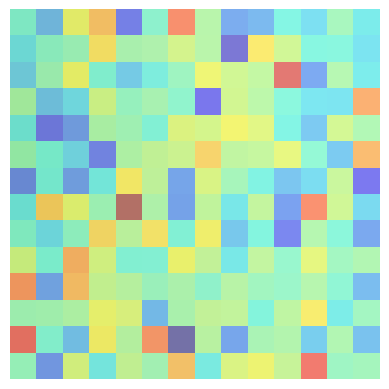

In [21]:
def _visualization_cls_attention(atten, image_size=224, patch_size=16):
    '''cls 토큰이 각 패치를 얼마나 주목하는지 시각화
    attention : [1, heads, 197, 197]
    '''
    # cls - > patch attention만 추출
    cls_atten = atten[0, :, 0, 1:]  # [heads, 196]
    # head 평균
    cls_atten_mean = cls_atten.mean(dim = 0)  # [196]
    # 14 x 14 reshape
    grid_size = image_size // patch_size
    atten_map = cls_atten_mean.reshape(grid_size, grid_size)
    atten_map = atten_map/ atten_map.max()
    return atten_map.detach().cpu().numpy()

# 더미이미지 + attention 시각화
import requests
from PIL import Image
from io import BytesIO

def demo_cls_attention_visualization(is_dummy:bool = True, url:str = None,image_size:str = 224):
    # 1. 더미 이미지
    if is_dummy :
        image = np.random.rand(224,224,3)
    elif url.startswith('http'):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image = image.resize((image_size, image_size))
        image = np.array(image) / 255.0  # 정규화
    else:  # 로컬 이미지 로드
        image = Image.open(url).convert('RGB')
        image = image.resize((image_size, image_size))
        image = np.array(image) / 255.0  # 정규화

    # self_attention 계산
    atten = self_attention()
    # 3. attention map 생성
    atten_map = _visualization_cls_attention(atten)
    # 시각화
    plt.imshow(image)
    plt.imshow(atten_map, cmap = 'jet', alpha=0.5)
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    url = 'C:/python_src/7.Multimodal/Cat03.jpg'
    demo_cls_attention_visualization(False, url=url)